# Modeling Nonstationary Data with an Adaptive Bayesian Neural Network Based on Random Walk Priors

# Nonstationary predictive model

Imagine the following dynamics:

- There exists a predictive signal.
- Market participants find it in the data.
- Their efforts to profit from it causes the relationship to get arbitraged away.
- Historic data still show evidence of the signal.
- Slowly adapting traders still try to trade based on it.
- This causes the signal to be predictive in the opposite direction.
- Low level weights are still useful; use all data to encode features.
- But layers further towards the output layer need to adapt.
- A pricipled way to update layers enables one to be one step ahead.


Transfer learning is used to increase data efficiency by training the lower layers of a neural network on some different but related data. The the layers closer to the output layer are trained on the actual data of interest, while the layers closer to the input are either completely frozen or trained with a progressively smaller learning rate. In a Bayesian framework the stepsize of each layer can be modeled as a learnable parameter. 

## Panel model
- $p$ assets.
- $n$ time steps.
- the optimal weights of the last layer change smoothly over time.


Consider the neural network

$$
\mathbf{y}_t = f(\mathbf{\Theta}, \mathbf{X}_t),
$$

where $f$ is a composition of functions and $\mathbf{\Theta}$ are the learnable parameters. We assume that our data is not iid and that $\mathbf{\Theta}$ is changing over time. We thus need a different $\mathbf{\Theta}_t$ for every $t$:

$$
\mathbf{y}_t = f(\mathbf{\Theta_t}, \mathbf{X}_t)
$$

In order to avoid overfitting, $\mathbf{\Theta}_t$ needs to be constrained. We will assume that while $\mathbf{\Theta}_t$ is changing over time, it will do so rather gradually by placing a random-walk prior on it:

$$
\mathbf{\Theta}_t \sim \mathcal{N}(\mathbf{\Theta}_{t-1}, \mathbf{\Sigma})
$$

So $\mathbf{\Theta}_t$ is allowed to only deviate a little bit (determined by the step-width $s$) from its previous value $\mathbf{\Theta}_{t-1}$. $s$ can be thought of as a stability parameter -- how fast is the world around you changing. 

[Thomas Wiecki](https://twitter/twiecki) proposed an adaptive classifier.

The idea detailed below is strongly influenced by his blog post: https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/random_walk_deep_net.ipynb
.

In [1]:
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from pymc3 import HalfNormal, GaussianRandomWalk, Bernoulli
from pymc3.math import sigmoid
import theano.tensor as tt

import warnings
from scipy import VisibleDeprecationWarning
warnings.filterwarnings("ignore", category=VisibleDeprecationWarning) 

sns.set_context('notebook')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# Generate Data

The following snipped generate a nonlinear panel data set with time-varying ground truth parameter.

In [2]:
import matplotlib.animation as animation
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# %matplotlib notebook


# number of time steps (e.g. days)
n = 100

# number of assets
p = 100

#features
# x = np.random.normal(0, 1, size=(n, p, 2))
x = np.random.uniform(-5, 5, size=(n, p, 2))
x1 = x[:, :, 0]
x2 = x[:, :, 1]

# coefficient
beta = np.linspace(-0.5, 0.5, n)

# ground truth model
def f(x1, x2, beta):
    y = beta[:,None]*x1*x2
    return y 

# dependent variable (log-returns)
y = f(x1, x2, beta) + np.random.normal(0, 1/2, size=(n, p))




Plotting the dependent variable as surface over the feature space through time results in this animation:

In [19]:
import base64
from tempfile import NamedTemporaryFile
from IPython.display import HTML


VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""


def anim_to_html(anim, name):
    if not hasattr(anim, '_encoded_video'):
        anim.save(f"{name}.mp4", fps=20, extra_args=['-vcodec', 'libx264'])

        video = open(f"{name}.mp4","rb").read()

    anim._encoded_video = base64.b64encode(video).decode('utf-8')
    return VIDEO_TAG.format(anim._encoded_video)

def display_animation(anim, name):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim, name))




In [20]:

def animate(i):
    beta = (n/2-i)/n
    ax.clear() 
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_zlim(-5, 5)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('y');
    plot = ax.plot_trisurf(x1[i, :], x2[i, :], y[i, :],
                cmap='viridis', edgecolor='none', alpha=0.8);



fig = plt.figure()
ax = plt.axes(projection='3d')


anim = animation.FuncAnimation(fig, animate,
                               frames=(n),
                               interval=50, repeat=True, blit=False)
display_animation(anim, 'target')

In [5]:
np.random.seed(123)
X = x.reshape(n*p, 2)
Y = y.reshape(n*p)
ann_input = theano.shared(X)
ann_output = theano.shared(Y)

n_hidden = [10, 5]
interval = p

# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden[0]).astype(theano.config.floatX)
init_2 = np.random.randn(n_hidden[0], n_hidden[1]).astype(theano.config.floatX)
init_out = np.random.randn(n_hidden[1]).astype(theano.config.floatX)
    
with pm.Model() as neural_network:
    # Weights from input to hidden layer
#     step_size1 = pm.HalfNormal('step_size1', sd=np.ones(n_hidden[0]+1), 
#                               shape=n_hidden[0]+1
#                              )
#     step_size2 = pm.HalfNormal('step_size2', sd=np.ones(n_hidden[1]+1), 
#                               shape=n_hidden[1]+1
#                              )
    step_size3 = pm.HalfNormal('step_size3', sd=10)

    sigma = pm.HalfNormal('sigma', sd=10)
    
    ##################### Input layer to hidden 1 ######################################

        
    weights_in_1 = pm.Normal('w1', mu=0, sd=1., 
                            shape=(1, X.shape[1], n_hidden[0]),
                            testval=init_1)
    weights_in_1_rep = tt.repeat(weights_in_1, 
                                ann_input.shape[0], axis=0)
    
    
#     weights_in_1 = pm.GaussianRandomWalk('w1', sd=step_size1, 
#                                          shape=(interval, X.shape[1], n_hidden[0]),
#                                          testval=np.tile(init_1, (interval, 1, 1))
#                                         )
    
#     weights_in_1_rep = tt.repeat(weights_in_1, 
#                                  ann_input.shape[0] // interval, axis=0)
    

    
    ##################### Hidden layer 1 to 2###########################################
    
    weights_1_2 = pm.Normal('w2', mu=0, sd=1., 
                            shape=(1, n_hidden[0], n_hidden[1]),
                            testval=init_2)
    
    weights_1_2_rep = tt.repeat(weights_1_2, 
                                ann_input.shape[0], axis=0)

#     weights_1_2 = pm.GaussianRandomWalk('w2', sd=step_size2, 
#                                          shape=(interval, n_hidden[0], n_hidden[1]),
#                                          testval=np.tile(init_2, (interval, 1, 1))
#                                         )
    
#     weights_1_2_rep = tt.repeat(weights_1_2, 
#                                 ann_input.shape[0] // interval, axis=0)
    
    
   ##################### Hidden layer 2 to output layer #################################

    
#     weights_2_out = pm.Normal('w3', mu=0, sd=1.,
#                               shape=(1, n_hidden[1]),
#                               testval=init_out)
#     weights_2_out_rep = tt.repeat(weights_2_out, 
#                                   ann_input.shape[0], axis=0)
    
    weights_2_out = pm.GaussianRandomWalk('w3', sd=step_size3, 
                                         shape=(interval, n_hidden[1]),
                                         testval=np.tile(init_out, (interval, 1))
                                        )
    weights_2_out_rep = tt.repeat(weights_2_out, 
                                 ann_input.shape[0] // interval, axis=0)
    
    
    # Build neural-network using relu activation function
    act_1 = tt.nnet.relu(tt.batched_dot(ann_input, 
                         weights_in_1_rep))
    act_2 = tt.nnet.relu(tt.batched_dot(act_1, 
                         weights_1_2_rep))
    
    intercept = pm.Normal('intercept', mu=0, sd=10)
    act_out = tt.batched_dot(act_2, weights_2_out_rep) + intercept
        
    # linear output layer
    out = pm.Normal('out', 
                    act_out,
                    sigma,
                    observed=ann_output)

In [6]:
#hide

# a larger net (still needs debugging)

# np.random.seed(123)
# X = x.reshape(n*p, 2)
# Y = y.reshape(n*p)
# ann_input = theano.shared(X)
# ann_output = theano.shared(Y)

# n_hidden = [10, 10, 10]
# interval = p
# # Initialize random weights between each layer
# init_1 = np.random.randn(X.shape[1], n_hidden[0]).astype(theano.config.floatX)
# init_2 = np.random.randn(n_hidden[0], n_hidden[1]).astype(theano.config.floatX)
# init_3 = np.random.randn(n_hidden[1], n_hidden[2]).astype(theano.config.floatX)
# init_out = np.random.randn(n_hidden[2]).astype(theano.config.floatX)
    
# with pm.Model() as neural_network:
#     # Weights from input to hidden layer
# #     step_size1 = pm.HalfNormal('step_size1', sd=np.ones(n_hidden[0]+1), 
# #                               shape=n_hidden[0]+1
# #                              )
# #     step_size2 = pm.HalfNormal('step_size2', sd=np.ones(n_hidden[1]+1), 
# #                               shape=n_hidden[1]+1
# #                              )
# #     step_size3 = pm.HalfNormal('step_size3', sd=np.ones(n_hidden[2]+1), 
# #                               shape=n_hidden[2]+1
# #                              )
#     step_size4 = pm.HalfNormal('step_size4', sd=10)
#     sigma = pm.HalfNormal('sigma', sd=10)
    
#     ##################### Input layer to hidden 1 ######################################

        
#     weights_in_1 = pm.Normal('w1', mu=0, sd=1., 
#                             shape=(1, X.shape[1], n_hidden[0]),
#                             testval=init_1)
#     weights_in_1_rep = tt.repeat(weights_in_1, 
#                                 ann_input.shape[0], axis=0)
    
    
# #     weights_in_1 = pm.GaussianRandomWalk('w1', sd=step_size1, 
# #                                          shape=(interval, X.shape[1], n_hidden[0]),
# #                                          testval=np.tile(init_1, (interval, 1, 1))
# #                                         )
    
# #     weights_in_1_rep = tt.repeat(weights_in_1, 
# #                                  ann_input.shape[0] // interval, axis=0)
    

    
#     ##################### Hidden layer 1 to 2###########################################
    
#     weights_1_2 = pm.Normal('w2', mu=0, sd=1., 
#                             shape=(1, n_hidden[0], n_hidden[1]),
#                             testval=init_2)
    
#     weights_1_2_rep = tt.repeat(weights_1_2, 
#                                 ann_input.shape[0], axis=0)

# #     weights_1_2 = pm.GaussianRandomWalk('w2', sd=step_size2, 
# #                                          shape=(interval, n_hidden[0], n_hidden[1]),
# #                                          testval=np.tile(init_2, (interval, 1, 1))
# #                                         )
    
# #     weights_1_2_rep = tt.repeat(weights_1_2, 
# #                                 ann_input.shape[0] // interval, axis=0)
    
    
#    ##################### Hidden layer 2 to 3 #################################

    
#     weights_2_3 = pm.Normal('w3', mu=0, sd=1.,
#                               shape=(1, n_hidden[1], n_hidden[2]),
#                               testval=init_3)
#     weights_2_3_rep = tt.repeat(weights_2_3, 
#                                   ann_input.shape[0], axis=0)
    
# #     weights_2_3 = pm.GaussianRandomWalk('w3', sd=step_size3, 
# #                                          shape=(interval, n_hidden[1]),
# #                                          testval=np.tile(init_3, (interval, 1))
# #                                         )
# #     weights_2_3_rep = tt.repeat(weights_2_3, 
# #                                  ann_input.shape[0] // interval, axis=0)

#  ##################### Hidden layer 3 to out #################################


    
#     weights_3_out = pm.GaussianRandomWalk('w4', sd=step_size4, 
#                                          shape=(interval, n_hidden[2]),
#                                          testval=np.tile(init_out, (interval, 1))
#                                         )
#     weights_3_out_rep = tt.repeat(weights_3_out, 
#                                  ann_input.shape[0] // interval, axis=0)
    
    
#     # Build neural-network using relu activation function
#     act_1 = tt.nnet.relu(tt.batched_dot(ann_input, 
#                          weights_in_1_rep))
#     act_2 = tt.nnet.relu(tt.batched_dot(act_1, 
#                          weights_1_2_rep))
#     act_3 = tt.nnet.relu(tt.batched_dot(act_2, 
#                          weights_2_3_rep))
    
#     # linear output layer
#     intercept = pm.Normal('intercept', mu=0, sd=10)
#     act_out = tt.batched_dot(act_3, weights_3_out_rep) + intercept
        
#     out = pm.Normal('out', 
#                     act_out,
#                     sigma,
#                     observed=ann_output)


In [7]:
N = 200000
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=N, method=inference)

Finished [100%]: Average Loss = 597.07


In [8]:
with neural_network:
    trace = approx.sample(draws=1000)

In [9]:
# hide
# Alternatively use NUTS

# with neural_network:
#     trace = pm.sample(1000, tune=200)

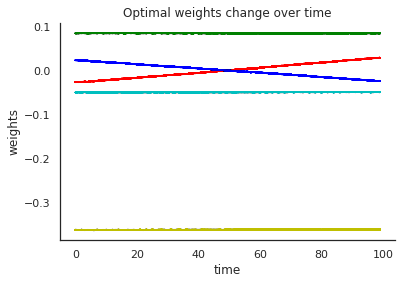

In [11]:
plt.plot(trace['w3'][200:, :, 0].T, alpha=.05, color='r');
plt.plot(trace['w3'][200:, :, 1].T, alpha=.05, color='b');
plt.plot(trace['w3'][200:, :, 2].T, alpha=.05, color='g');
plt.plot(trace['w3'][200:, :, 3].T, alpha=.05, color='c');
plt.plot(trace['w3'][200:, :, 4].T, alpha=.05, color='y');
plt.xlabel('time'); plt.ylabel('weights');
plt.title('Optimal weights change over time'); 
sns.despine();

In [18]:
#hide
# plt.plot(trace['w4'][200:, :, 0].T, alpha=.05, color='r');
# plt.plot(trace['w4'][200:, :, 1].T, alpha=.05, color='b');
# plt.plot(trace['w4'][200:, :, 2].T, alpha=.05, color='g');
# plt.plot(trace['w4'][200:, :, 3].T, alpha=.05, color='c');
# plt.plot(trace['w4'][200:, :, 4].T, alpha=.05, color='y');
# plt.xlabel('time'); plt.ylabel('weights');
# plt.title('Optimal weights change over time'); 
# sns.despine();

In [12]:
ppc = pm.sample_posterior_predictive(trace, model=neural_network, samples=1000)


In [13]:
y_pred = ppc['out'].mean(0).reshape(n,p)


In [14]:
def mse(y_hat, y):
    return ((y_hat - y)**2).mean()
    
mse(y_pred, y)    

0.48838951276186865

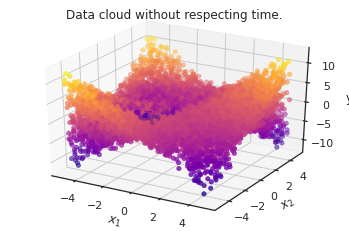

In [15]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('y');
ax.scatter(x1, x2, y, c=y, cmap='plasma', linewidth=0.5);
plt.title("Data cloud without respecting time.")
plt.show()

In [21]:
def animate(i):
    beta = (n/2-i)/n
    ax.clear() 
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_zlim(-5, 5)
    
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('y');
    plot = ax.plot_trisurf(x1[i, :], x2[i, :], y_pred[i, :],
                cmap='plasma', edgecolor='none', alpha=0.5);

    ax.scatter(x1[i, :], x2[i, :], y[i, :], c=y[i, :], cmap='plasma', linewidth=0.9);


fig = plt.figure()
ax = plt.axes(projection='3d')
anim = animation.FuncAnimation(fig, animate,
                               frames=(n),
                               interval=50, repeat=True, blit=False)
# plt.show()
display_animation(anim, 'prediction')

In [17]:
%load_ext watermark
%watermark -v -m -p numpy,scipy,theano,pymc3,matplotlib

CPython 3.8.5
IPython 7.17.0

numpy 1.19.1
scipy 1.5.2
theano 1.0.5
pymc3 3.9.3
matplotlib 3.2.2

compiler   : GCC 7.5.0
system     : Linux
release    : 4.4.0-83-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit


It worked! The surface of predictions follows the data cloud of true outcomes closely through time.